In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
# import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.layers import Dropout, GRU, Dense, Conv1D, Conv2D, Flatten
from keras.models import Sequential
import matplotlib.pyplot as plt
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

2024-08-25 11:14:33.262367: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def SMA(df, window_size):
    """
    Calculate the Simple Moving Average (SMA) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing at least the 'Close' column.
    window_size (int): The window size for calculating the SMA.
    
    Returns:
    Series: The SMA values.
    """
    return df['Close'].rolling(window=window_size).mean()

def EMA(df, window_size):
    """
    Calculate the Exponential Moving Average (EMA) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing at least the 'Close' column.
    window_size (int): The window size for calculating the EMA.
    
    Returns:
    Series: The EMA values.
    """
    return df['Close'].ewm(span=window_size).mean()

def MACD(df, short_window, long_window):
    """
    Calculate the Moving Average Convergence Divergence (MACD) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing at least the 'Close' column.
    short_window (int): The window size for the short EMA.
    long_window (int): The window size for the long EMA.
    
    Returns:
    Series: The MACD values.
    """
    short_EMA = EMA(df, short_window)
    long_EMA = EMA(df, long_window)
    return short_EMA - long_EMA

def RSI(df, window_size):
    """
    Calculate the Relative Strength Index (RSI) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing at least the 'Close' column.
    window_size (int): The window size for calculating the RSI.
    
    Returns:
    Series: The RSI values.
    """
    delta = df['Close'].diff()
    delta = delta[1:] 
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=window_size - 1, min_periods=window_size).mean()
    ema_down = down.ewm(com=window_size - 1, min_periods=window_size).mean()
    return ema_up / ema_down

def Bollinger_Bands(df, window_size):
    """
    Calculate the Bollinger Bands for the given df.
    
    Parameters:
    df (dfFrame): The input df containing at least the 'Close' column.
    window_size (int): The window size for calculating the Bollinger Bands.
    
    Returns:
    Tuple[Series, Series]: The upper and lower Bollinger Bands.
    """
    middle_band = SMA(df, window_size)
    std_dev = df['Close'].rolling(window=window_size).std()
    upper_band = middle_band + (std_dev * 2)
    lower_band = middle_band - (std_dev * 2)
    return upper_band, lower_band

def create_sequences(df, seq_length):
    """
    Create sequences of df for time series forecasting.
    
    Parameters:
    df (dfFrame): The input df.
    seq_length (int): The length of each sequence.
    
    Returns:
    Tuple[np.ndarray, np.ndarray]: Arrays of input sequences and corresponding targets.
    """
    xs = []
    ys = []
    
    for i in range(len(df) - seq_length - 1):
        x = df.iloc[i:(i + seq_length)].values
        y = df.iloc[(i + seq_length)]['Close']
        xs.append(x)
        ys.append(y)
        
    return np.array(xs), np.array(ys)

def gain(x):
    """
    Calculate the gain from an array of differences.
    
    Parameters:
    x (np.ndarray): The array of differences.
    
    Returns:
    float: The total gain.
    """
    return ((x > 0) * x).sum()

def loss(x):
    """
    Calculate the loss from an array of differences.
    
    Parameters:
    x (np.ndarray): The array of differences.
    
    Returns:
    float: The total loss.
    """
    return ((x < 0) * x).sum()

def MFI(df, n=14):
    """
    Calculate the Money Flow Index (MFI) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing 'High', 'Low', 'Close', and 'Volume' columns.
    n (int): The window size for calculating the MFI.
    
    Returns:
    np.ndarray: The MFI values.
    """
    high = df['High']
    low = df['Low']
    close = df['Close']
    volume = df['Volume']
    typical_price = (high + low + close) / 3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    mf_avg_gain = signed_mf.rolling(n).apply(gain, raw=True)
    mf_avg_loss = signed_mf.rolling(n).apply(loss, raw=True)
    return (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).to_numpy()

def ATR(df, n=14):
    """
    Calculate the Average True Range (ATR) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing 'High', 'Low', and 'Close' columns.
    n (int): The window size for calculating the ATR.
    
    Returns:
    np.ndarray: The ATR values.
    """
    high = df['High']
    low = df['Low']
    close = df['Close']
    tr = np.amax(np.vstack(((high - low).to_numpy(), (abs(high - close)).to_numpy(), (abs(low - close)).to_numpy())).T, axis=1)
    return pd.Series(tr).rolling(n).mean().to_numpy()

def ForceIndex(df, ndays): 
    """
    Calculate the Force Index for the given df.
    
    Parameters:
    df (dfFrame): The input df containing 'Close' and 'Volume' columns.
    ndays (int): The window size for calculating the Force Index.
    
    Returns:
    dfFrame: The df with the Force Index column added.
    """
    FI = pd.Series(df['Close'].diff(ndays) * df['Volume'], name='ForceIndex')
    df = df.join(FI)
    return df

def EMV(df, ndays): 
    """
    Calculate the Ease of Movement (EMV) for the given df.
    
    Parameters:
    df (dfFrame): The input df containing 'High', 'Low', and 'Volume' columns.
    ndays (int): The window size for calculating the EMV.
    
    Returns:
    dfFrame: The df with the EMV column added.
    """
    dm = ((df['High'] + df['Low']) / 2) - ((df['High'].shift(1) + df['Low'].shift(1)) / 2)
    br = (df['Volume'] / 100000000) / (df['High'] - df['Low'])
    EMV = dm / br 
    EMV_MA = pd.Series(EMV.rolling(ndays).mean(), name='EMV')
    df = df.join(EMV_MA)
    return df

def create_lagged_features(df, features_to_lag, lags_dict, lags):
    """
    Create lag features for specified columns in the dfFrame.
    
    Parameters:
    df (dfFrame): The input df.
    features_to_lag (list): List of column names for which to create lag features.
    lags (int): The number of lag features to create.
    
    Returns:
    dfFrame: The features with lags and the target values.
    """
    lagged_df = df.copy()
    
    # Creating lag features for specified columns
    for feature in features_to_lag:
        if feature in lags_dict:
            for lag in range(1, lags + 1):
                lagged_df[f'{feature}_lag_{lag}'] = lagged_df[feature].shift(lag)
    
    # Drop rows with NaN values (resulting from the lagging process)
    lagged_df = lagged_df.dropna()
    
    return lagged_df

def create_time_features(df):
    """
    Create time series features.
    """
    # df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

def add_lags(df):
    df['lag day high'] = df['High'].shift(1)
    df['lag day low'] = df['Low'].shift(1)
    df['lag day open'] = df['Open'].shift(1)
    df['lag day close'] = df['Close'].shift(1)
    df['lag week close'] = df['Close'].shift(5)
    df['lag month close'] = df['Close'].shift(20)
    df['lag quarter close'] = df['Close'].shift(60)
    df['lag year close'] = df['Close'].shift(252)
    return df


In [3]:
# Load df
df = pd.read_csv('GOOGL_large.csv')
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df = create_time_features(df)

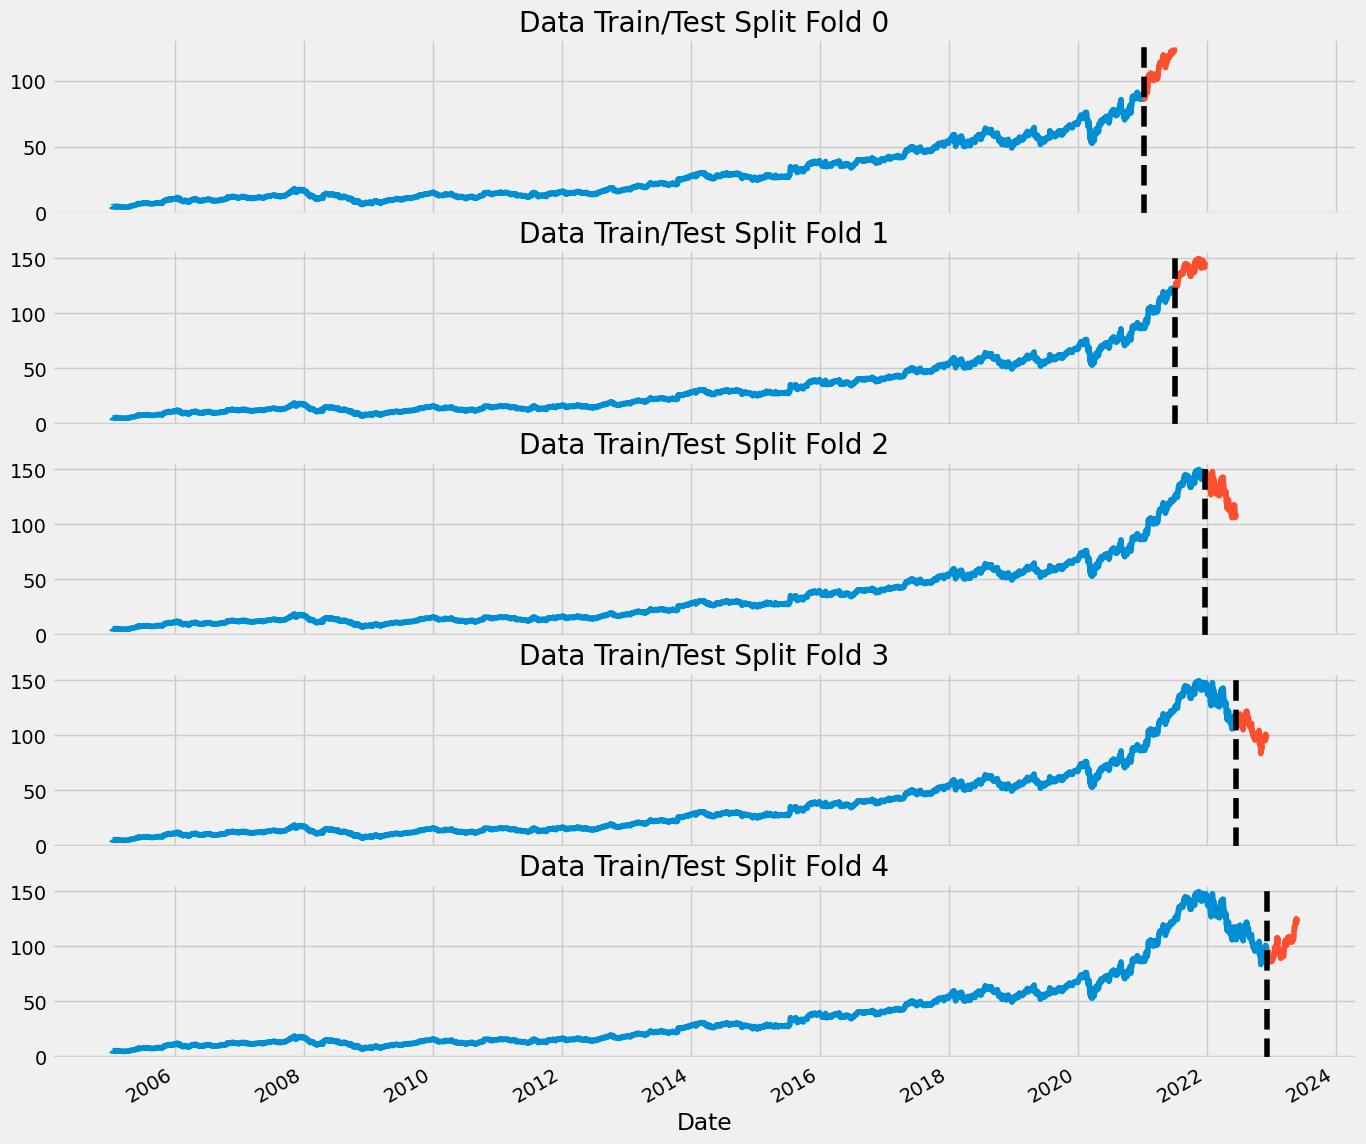

In [4]:
# Cross Validation data sets
tss = TimeSeriesSplit(n_splits=5, test_size=120, gap=0)
df = df.sort_index()
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Close'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Close'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [5]:
# Load df
df = pd.read_csv('GOOGL_large.csv')
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df = add_lags(df)
df['SMA'] = SMA(df, 14)
df['EMA'] = EMA(df, 14)
df['MACD'] = MACD(df, 12, 26)
df['RSI'] = RSI(df, 14)
df['Upper_band'], df['Lower_band'] = Bollinger_Bands(df, 14)
df['MFI'] = MFI(df, 14)
df['ATR'] = ATR(df, 14)
df['ForceIndex'] = ForceIndex(df, 14)['ForceIndex']
df['EMV'] = EMV(df, 14)['EMV']

In [6]:
# Create sequences of data with a length of `seq_length`
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)][FEATURES].values
        y = data.iloc[i + seq_length][TARGET]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag day high', 
                'lag day low', 
                'lag day open',
                # 'lag day close', 
                # 'lag week close', 
                # 'lag month close',
                'lag quarter close',
                'SMA', 'EMA', 'MACD', 'RSI', 'Upper_band', 
                'Lower_band', 'MFI', 'ATR', 'ForceIndex', 'EMV']
TARGET = 'Close'

tss = TimeSeriesSplit(n_splits=5, test_size=120, gap=0)
df = df.sort_index()
df = df.dropna()
columns_to_scale = ['Volume', 'SMA', 'EMA', 'MACD', 'RSI', 'ATR', 'ForceIndex', 'EMV', 'Upper_band', 'Lower_band']
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
fold = 0
preds = []
scores = []


for train_idx, val_idx in tss.split(df):
    train = df_scaled.iloc[train_idx]
    test = df_scaled.iloc[val_idx]


    train = create_time_features(train)
    test = create_time_features(test)
    seq_length = 3
    X_train, y_train = create_sequences(train, seq_length=3)  # Now each X_train sample has 3 timesteps
    X_test, y_test = create_sequences(test, seq_length=3)

    # Define 1D CNN model
    cnn_model = Sequential()
    cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(50, activation='relu'))
    cnn_model.add(Dense(1))

    # Compile and fit 1D CNN model
    cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['root_mean_squared_error'])
    cnn_model.fit(X_train, y_train, batch_size=64, epochs=100)


    y_pred = cnn_model.predict(X_test)
    prediction_index = test.index[seq_length:]  # Skip the first 'seq_length' rows to align with predictions
    preds.append(pd.DataFrame(y_pred, index=prediction_index, columns=['prediction']))
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Epoch 1/100


/Users/School/Documents/Github/ML_StockPriceForcasting/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6128.3999 - root_mean_squared_error: 73.7494  
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 169.2662 - root_mean_squared_error: 12.8055
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0064 - root_mean_squared_error: 2.8022 
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5779 - root_mean_squared_error: 1.8902
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9066 - root_mean_squared_error: 1.9758
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4208 - root_mean_squared_error: 1.8478
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4038 - root_mean_squared_error: 1.8405
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5120 - root_mean_squared_error: 1.8715
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2529 - root_mean_squared_error: 1.8026
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9138 - root_mean_squared_error: 1.7060
E

/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Epoch 1/100


/Users/School/Documents/Github/ML_StockPriceForcasting/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 570.0632 - root_mean_squared_error: 23.0705
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9490 - root_mean_squared_error: 2.2194
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1424 - root_mean_squared_error: 1.7725
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4385 - root_mean_squared_error: 1.5598
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3216 - root_mean_squared_error: 1.5225
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3429 - root_mean_squared_error: 1.5297
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8227 - root_mean_squared_error: 1.6770
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3581 - root_mean_squared_error: 1.5340
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2680 - root_mean_squared_error: 1.5044
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0084 - root_mean_squared_error: 1.4162
Epoch 11

/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Epoch 1/100


/Users/School/Documents/Github/ML_StockPriceForcasting/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 944.7863 - root_mean_squared_error: 29.5045 
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6707 - root_mean_squared_error: 2.5817
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6109 - root_mean_squared_error: 2.3660
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3148 - root_mean_squared_error: 2.2959
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8771 - root_mean_squared_error: 2.2057
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0441 - root_mean_squared_error: 2.0104
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5773 - root_mean_squared_error: 1.8900
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4270 - root_mean_squared_error: 1.8448
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3438 - root_mean_squared_error: 1.8173
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8984 - root_mean_squared_error: 1.9726
Epoch 1

/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Epoch 1/100


/Users/School/Documents/Github/ML_StockPriceForcasting/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10536.3604 - root_mean_squared_error: 95.6511 
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171.8887 - root_mean_squared_error: 12.9516
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13.5305 - root_mean_squared_error: 3.6677
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2327 - root_mean_squared_error: 2.8664
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4675 - root_mean_squared_error: 2.5424
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9435 - root_mean_squared_error: 2.4361
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0400 - root_mean_squared_error: 2.4483 
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0979 - root_mean_squared_error: 2.2543
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0150 - root_mean_squared_error: 2.0030
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9313 - root_mean_squared_error: 1.9822


/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Epoch 1/100


/Users/School/Documents/Github/ML_StockPriceForcasting/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1139.6506 - root_mean_squared_error: 32.2247
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.2083 - root_mean_squared_error: 3.3416
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6588 - root_mean_squared_error: 2.9384
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3606 - root_mean_squared_error: 2.8863
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0462 - root_mean_squared_error: 2.6526
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7320 - root_mean_squared_error: 2.3909
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7099 - root_mean_squared_error: 2.5869
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2124 - root_mean_squared_error: 2.2819
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3880 - root_mean_squared_error: 2.3136
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8497 - root_mean_squared_error: 1.9606
Epoch 

In [7]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3.7685
Fold scores:[3.1882777749948414, 3.3196453017654615, 5.047613631349683, 4.031245033065016, 3.2556370088950706]


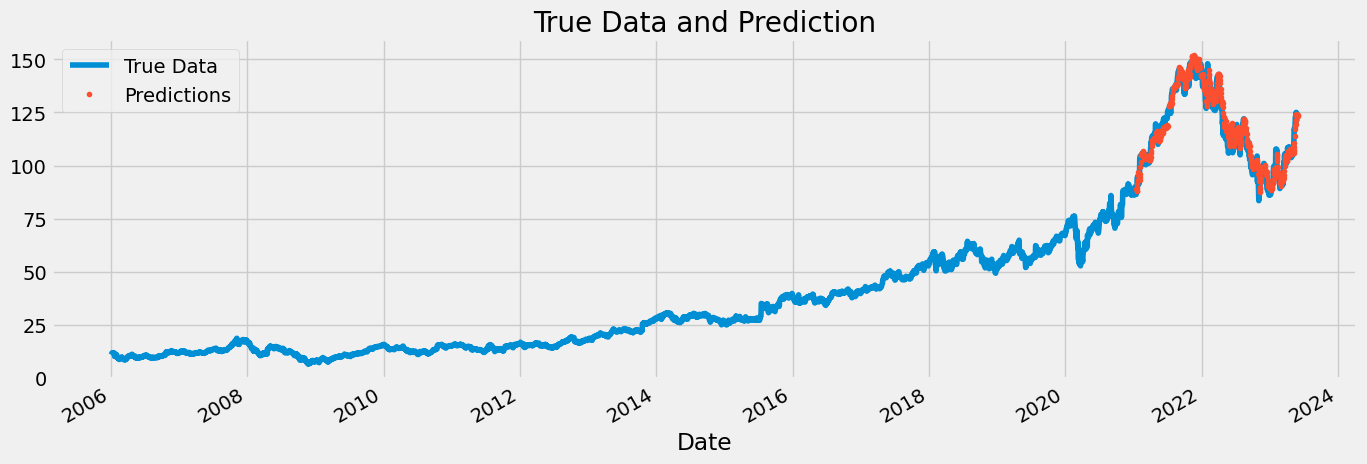

In [8]:
# Concatenate all predictions into a single DataFrame
predictions = pd.concat(preds)

# Merge predictions back into the original DataFrame
df = df.merge(predictions, how='left', left_index=True, right_index=True)

# Plotting
ax = df[['Close']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['True Data', 'Predictions'])
ax.set_title('True Data and Prediction')
plt.show()

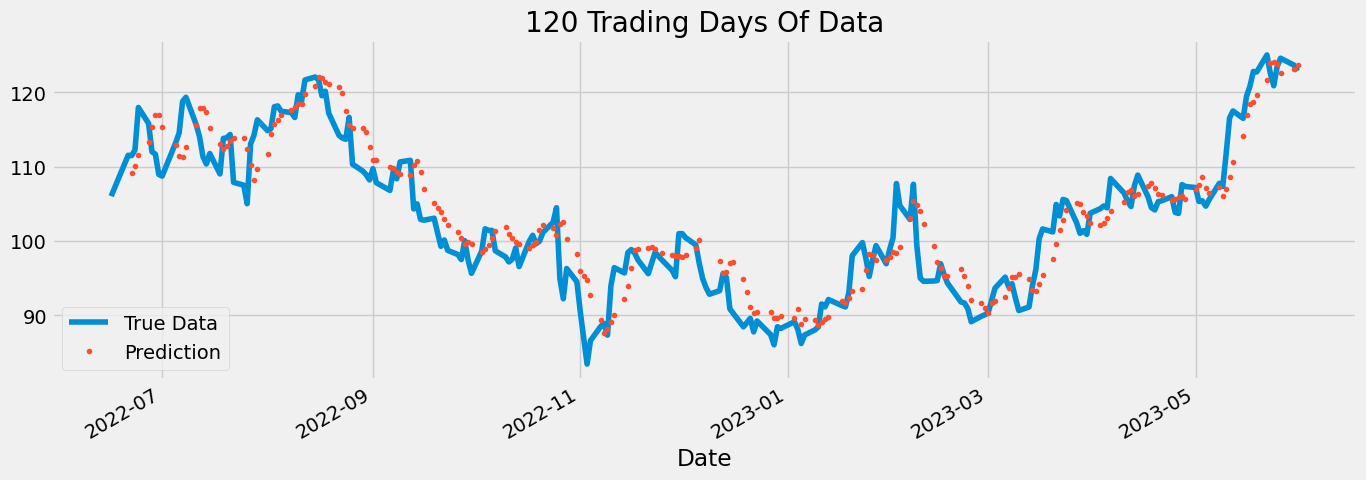

In [9]:
ax = df.loc[df.tail(240).index]['Close'] \
    .plot(figsize=(15, 5), title='120 Trading Days Of Data')
df.loc[df.tail(240).index]['prediction'] \
    .plot(style='.')
plt.legend(['True Data','Prediction'])
plt.show()

In [10]:
# Load df
df = pd.read_csv('GOOGL_large.csv')
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df = add_lags(df)
df['SMA'] = SMA(df, 14)
df['EMA'] = EMA(df, 14)
df['MACD'] = MACD(df, 12, 26)
df['RSI'] = RSI(df, 14)
df['Upper_band'], df['Lower_band'] = Bollinger_Bands(df, 14)
df['MFI'] = MFI(df, 14)
df['ATR'] = ATR(df, 14)
df['ForceIndex'] = ForceIndex(df, 14)['ForceIndex']
df['EMV'] = EMV(df, 14)['EMV']

In [11]:
# LSTM Model

# Create sequences of data with a length of `seq_length`
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)][FEATURES].values
        y = data.iloc[i + seq_length][TARGET]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag day high', 
                'lag day low', 
                'lag day open',
                # 'lag day close', 
                # 'lag week close', 
                # 'lag month close',
                'lag quarter close',
                'SMA', 'EMA', 'MACD', 'RSI', 'Upper_band', 
                'Lower_band', 'MFI', 'ATR', 'ForceIndex', 'EMV']
TARGET = 'Close'


tss = TimeSeriesSplit(n_splits=5, test_size=120, gap=0) #5->10
df = df.sort_index()
df = df.dropna()
columns_to_scale = ['Volume', 'SMA', 'EMA', 'MACD', 'RSI', 'ATR', 'ForceIndex', 'EMV', 'Upper_band', 'Lower_band']
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df_scaled.iloc[train_idx]
    test = df_scaled.iloc[val_idx]


    train = create_time_features(train)
    test = create_time_features(test)


    # FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
    #             'lag day high', 
    #             'lag day low', 
    #             'lag day open',
    #             # 'lag day close', 
    #             # 'lag week close', 
    #             # 'lag month close',
    #             'lag quarter close',
    #             'SMA', 'EMA', 'MACD', 'RSI', 'Upper_band', 
    #             'Lower_band', 'MFI', 'ATR', 'ForceIndex', 'EMV']
    # TARGET = 'Close'

    seq_length = 20 # changed 3->20 , 20->10
    X_train, y_train = create_sequences(train, seq_length=seq_length)  # Now each X_train sample has 3 timesteps
    X_test, y_test = create_sequences(test, seq_length=seq_length)


    # X_train = train[FEATURES]
    # y_train = train[TARGET]

    # X_test = test[FEATURES]
    # y_test = test[TARGET]

    lstm_model = Sequential()
    lstm_model.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) #64->256->128
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(units=256, return_sequences=False)) #64->256->128
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(units=128)) #64->128->128
    lstm_model.add(Dense(units=1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['root_mean_squared_error'])
    lstm_model.fit(X_train, y_train, epochs=15, batch_size=32) # 100->50 and 64->32  change again 50->25 and 32->16 now 50->15 and 32->4 4->32


    y_pred = lstm_model.predict(X_test)
    prediction_index = test.index[seq_length:]  # Skip the first 'seq_length' rows to align with predictions
    preds.append(pd.DataFrame(y_pred, index=prediction_index, columns=['prediction']))
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Epoch 1/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - loss: 484.4343 - root_mean_squared_error: 21.8738
Epoch 2/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 24s 202ms/step - loss: 29.7520 - root_mean_squared_error: 5.4465
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 24s 203ms/step - loss: 15.5149 - root_mean_squared_error: 3.9371
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 23s 196ms/step - loss: 12.6459 - root_mean_squared_error: 3.5549
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 186ms/step - loss: 12.4954 - root_mean_squared_error: 3.5329
Epoch 6/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 25s 210ms/step - loss: 10.7435 - root_mean_squared_error: 3.2752
Epoch 7/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - loss: 11.7085 - root_mean_squared_error: 3.4209
Epoch 8/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 26s 218ms/step - loss: 10.1030 - root_mean_squared_error: 3.1759
Epoch 9/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - loss: 10.8504 - root_mean_squared_error: 3.2932
Epoch 10/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 22s 191ms/st

/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Epoch 1/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - loss: 689.0118 - root_mean_squared_error: 26.1337
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 25s 204ms/step - loss: 58.4785 - root_mean_squared_error: 7.6401
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 23s 185ms/step - loss: 24.1876 - root_mean_squared_error: 4.9131
Epoch 4/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 23s 192ms/step - loss: 22.0544 - root_mean_squared_error: 4.6852
Epoch 5/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - loss: 20.1262 - root_mean_squared_error: 4.4795
Epoch 6/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 22s 183ms/step - loss: 22.0337 - root_mean_squared_error: 4.6910
Epoch 7/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - loss: 16.5816 - root_mean_squared_error: 4.0698
Epoch 8/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 24s 193ms/step - loss: 12.7719 - root_mean_squared_error: 3.5704
Epoch 9/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 222ms/step - loss: 15.3760 - root_mean_squared_error: 3.9143
Epoch 10/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 22s 179ms/st

/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Epoch 1/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 28s 187ms/step - loss: 1077.0322 - root_mean_squared_error: 32.4317
Epoch 2/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - loss: 73.3446 - root_mean_squared_error: 8.5516
Epoch 3/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - loss: 39.3135 - root_mean_squared_error: 6.2635
Epoch 4/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 186ms/step - loss: 36.6573 - root_mean_squared_error: 6.0466
Epoch 5/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 189ms/step - loss: 31.4589 - root_mean_squared_error: 5.6066
Epoch 6/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 176ms/step - loss: 42.9504 - root_mean_squared_error: 6.5338
Epoch 7/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 21s 165ms/step - loss: 25.3825 - root_mean_squared_error: 5.0328
Epoch 8/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - loss: 45.0330 - root_mean_squared_error: 6.6569
Epoch 9/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 182ms/step - loss: 20.2227 - root_mean_squared_error: 4.4725
Epoch 10/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 21s 165ms/s

/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Epoch 1/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - loss: 1160.3679 - root_mean_squared_error: 33.8887
Epoch 2/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - loss: 75.8998 - root_mean_squared_error: 8.6812
Epoch 3/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - loss: 39.2218 - root_mean_squared_error: 6.2584
Epoch 4/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - loss: 44.5311 - root_mean_squared_error: 6.6597
Epoch 5/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - loss: 36.3792 - root_mean_squared_error: 6.0255
Epoch 6/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - loss: 27.2056 - root_mean_squared_error: 5.2103
Epoch 7/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - loss: 28.2133 - root_mean_squared_error: 5.3065
Epoch 8/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - loss: 28.9656 - root_mean_squared_error: 5.3796
Epoch 9/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 24s 184ms/step - loss: 21.2360 - root_mean_squared_error: 4.6039
Epoch 10/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 165ms/s

/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Epoch 1/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - loss: 1369.4260 - root_mean_squared_error: 36.3385
Epoch 2/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - loss: 81.9090 - root_mean_squared_error: 8.9337
Epoch 3/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - loss: 33.4693 - root_mean_squared_error: 5.7761
Epoch 4/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - loss: 31.1439 - root_mean_squared_error: 5.5732
Epoch 5/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - loss: 36.1869 - root_mean_squared_error: 6.0085
Epoch 6/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - loss: 34.0091 - root_mean_squared_error: 5.8039
Epoch 7/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - loss: 26.3923 - root_mean_squared_error: 5.1335
Epoch 8/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - loss: 27.8861 - root_mean_squared_error: 5.2751
Epoch 9/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - loss: 21.5255 - root_mean_squared_error: 4.6321
Epoch 10/15
133/133 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/s

In [12]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 15.1464
Fold scores:[29.384500898711718, 18.977930675834678, 9.148681000859645, 11.22075830628614, 7.000350584433772]


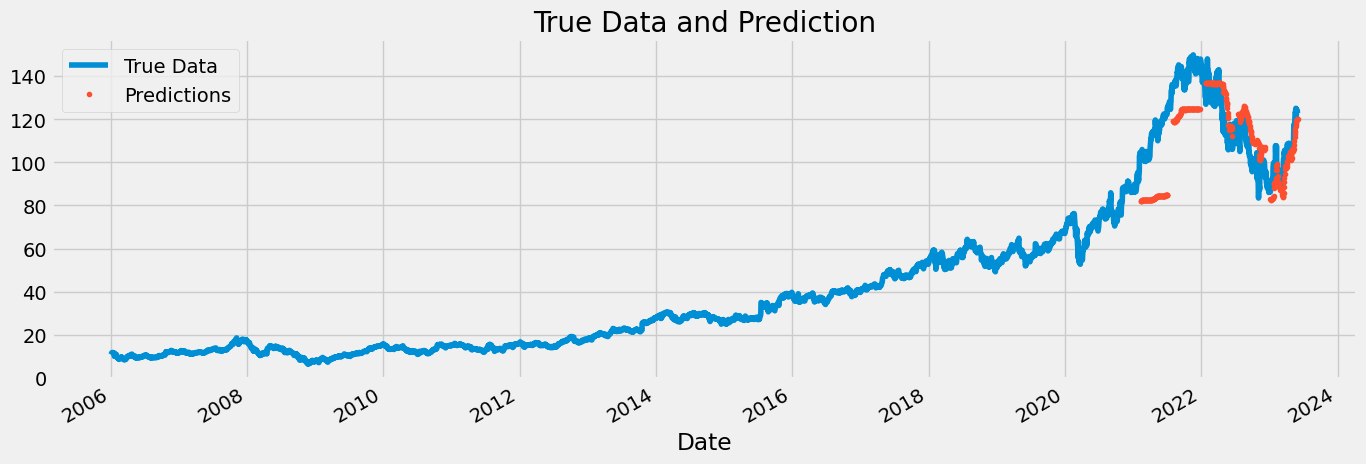

In [13]:
# test['prediction'] = lstm_model.predict(X_test)
# df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
# ax = df[['Close']].plot(figsize=(15, 5))
# df['prediction'].plot(ax=ax, style='.')
# plt.legend(['True Data', 'Predictions'])
# ax.set_title('True Data and Prediction')
# plt.show()

# Concatenate all predictions into a single DataFrame
predictions = pd.concat(preds)

# Merge predictions back into the original DataFrame
df = df.merge(predictions, how='left', left_index=True, right_index=True)

# Plotting
ax = df[['Close']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['True Data', 'Predictions'])
ax.set_title('True Data and Prediction')
plt.show()

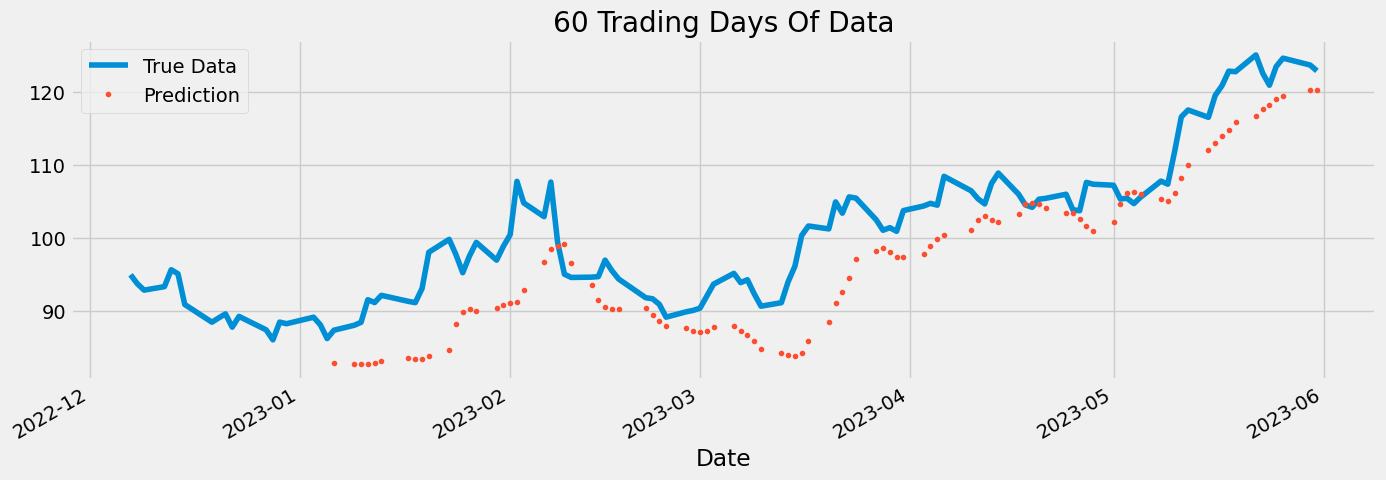

In [14]:
ax = df.loc[df.tail(120).index]['Close'] \
    .plot(figsize=(15, 5), title='60 Trading Days Of Data')
df.loc[df.tail(120).index]['prediction'] \
    .plot(style='.')
plt.legend(['True Data','Prediction'])
plt.show()

In [15]:

# Create sequences of data with a length of `seq_length`
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length)][FEATURES].values
        y = data.iloc[i + seq_length][TARGET]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag day high', 
                'lag day low', 
                'lag day open',
                # 'lag day close', 
                # 'lag week close', 
                # 'lag month close',
                'lag quarter close',
                'SMA', 'EMA', 'MACD', 'RSI', 'Upper_band', 
                'Lower_band', 'MFI', 'ATR', 'ForceIndex', 'EMV']
TARGET = 'Close'


df = pd.read_csv('GOOGL_large.csv')
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df = add_lags(df)
df['SMA'] = SMA(df, 14)
df['EMA'] = EMA(df, 14)
df['MACD'] = MACD(df, 12, 26)
df['RSI'] = RSI(df, 14)
df['Upper_band'], df['Lower_band'] = Bollinger_Bands(df, 14)
df['MFI'] = MFI(df, 14)
df['ATR'] = ATR(df, 14)
df['ForceIndex'] = ForceIndex(df, 14)['ForceIndex']
df['EMV'] = EMV(df, 14)['EMV']
df = add_lags(df)


tss = TimeSeriesSplit(n_splits=5, test_size=120, gap=0)
df = df.sort_index()
df = df.dropna()
columns_to_scale = ['Volume', 'SMA', 'EMA', 'MACD', 'RSI', 'ATR', 'ForceIndex', 'EMV', 'Upper_band', 'Lower_band']
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [16]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df_scaled.iloc[train_idx]
    test = df_scaled.iloc[val_idx]


    train = create_time_features(train)
    test = create_time_features(test)

    # FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
    #             'lag day high', 
    #             'lag day low', 
    #             'lag day open',
    #             # 'lag day close', 
    #             # 'lag week close', 
    #             # 'lag month close',
    #             'lag quarter close',
    #             'SMA', 'EMA', 'MACD', 'RSI', 'Upper_band', 
    #             'Lower_band', 'MFI', 'ATR', 'ForceIndex', 'EMV']
    # TARGET = 'Close'

    # X_train = train[FEATURES]
    # y_train = train[TARGET]

    # X_test = test[FEATURES]
    # y_test = test[TARGET]

    # Reshape X_train and X_test to be 3D (samples, timesteps, features)
    # X_train = np.expand_dims(X_train.values, axis=1)  # Shape: (samples, 1, features)
    # X_test = np.expand_dims(X_test.values, axis=1)    # Shape: (samples, 1, features)

    seq_length = 20 # changed 3->20 
    X_train, y_train = create_sequences(train, seq_length=seq_length)  # Now each X_train sample has 3 timesteps
    X_test, y_test = create_sequences(test, seq_length=seq_length)
    
    gru_model = Sequential()
    gru_model.add(GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) # 60->128
    gru_model.add(GRU(128, return_sequences=False)) # 60->128
    gru_model.add(Dense(64)) #30->64
    gru_model.add(Dense(1))

    # Compile and fit GRU model
    gru_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['root_mean_squared_error'])
    gru_model.fit(X_train, y_train, batch_size=64, epochs=100)

    y_pred = gru_model.predict(X_test)
    prediction_index = test.index[seq_length:]  # Skip the first 'seq_length' rows to align with predictions
    preds.append(pd.DataFrame(y_pred, index=prediction_index, columns=['prediction']))
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Epoch 1/100


/Users/School/Documents/Github/ML_StockPriceForcasting/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - loss: 739.5369 - root_mean_squared_error: 26.8689
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 419.2111 - root_mean_squared_error: 20.4726
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 260.5864 - root_mean_squared_error: 16.0431
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 61.3385 - root_mean_squared_error: 7.8038
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 33.7978 - root_mean_squared_error: 5.8130
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 34.3096 - root_mean_squared_error: 5.8534
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 33.3106 - root_mean_squared_error: 5.7698
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 30.8441 - root_mean_squared_error: 5.5469
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 23.4358 - root_mean_squared_error: 4.8400
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 22.3773 - root_mean_square

/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Epoch 1/100


/Users/School/Documents/Github/ML_StockPriceForcasting/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 970.4032 - root_mean_squared_error: 30.9116
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 601.5929 - root_mean_squared_error: 24.5214
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 481.8915 - root_mean_squared_error: 21.9032
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 99.0884 - root_mean_squared_error: 9.8865
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 25.7240 - root_mean_squared_error: 5.0628
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 23.3745 - root_mean_squared_error: 4.8319
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 14.8414 - root_mean_squared_error: 3.8500
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 24.9629 - root_mean_squared_error: 4.9775
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 13.0200 - root_mean_squared_error: 3.6030
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 12.0234 - root_mean_squared

/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Epoch 1/100


/Users/School/Documents/Github/ML_StockPriceForcasting/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 1290.3097 - root_mean_squared_error: 35.7618
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 825.4961 - root_mean_squared_error: 28.6452
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 101.6312 - root_mean_squared_error: 9.9901 
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 21.8854 - root_mean_squared_error: 4.6657
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 19.9886 - root_mean_squared_error: 4.4619
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 18.5638 - root_mean_squared_error: 4.3045
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 16.4141 - root_mean_squared_error: 4.0505
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 12.4979 - root_mean_squared_error: 3.5332
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 12.6009 - root_mean_squared_error: 3.5485
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 14.5130 - root_mean_square

/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Epoch 1/100


/Users/School/Documents/Github/ML_StockPriceForcasting/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 1502.6671 - root_mean_squared_error: 38.6626
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 985.2616 - root_mean_squared_error: 31.3837
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 253.7337 - root_mean_squared_error: 15.7251
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 31.3908 - root_mean_squared_error: 5.5970
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 17.7805 - root_mean_squared_error: 4.2145
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 12.7760 - root_mean_squared_error: 3.5729
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 15.4985 - root_mean_squared_error: 3.9334
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 12.3780 - root_mean_squared_error: 3.5150
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 13.7502 - root_mean_squared_error: 3.7065
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 10.5277 - root_mean_square

/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
/var/folders/58/7pbgz5q17hvf9bdj8jmfync80000gq/T/ipykernel_73335/3216723532.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Epoch 1/100


/Users/School/Documents/Github/ML_StockPriceForcasting/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 1830.5771 - root_mean_squared_error: 42.4836
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 1155.6156 - root_mean_squared_error: 33.9604
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 213.9617 - root_mean_squared_error: 14.1129
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 25.6194 - root_mean_squared_error: 5.0591
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 19.3614 - root_mean_squared_error: 4.3976
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 21.9998 - root_mean_squared_error: 4.6813
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 19.8812 - root_mean_squared_error: 4.4534
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 15.1452 - root_mean_squared_error: 3.8859
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 15.7127 - root_mean_squared_error: 3.9534
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 16.0569 - root_mean_squar

In [17]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 15.2842
Fold scores:[25.238865494498405, 23.129708250605706, 11.10350302002817, 6.925513894868263, 10.023167794753428]


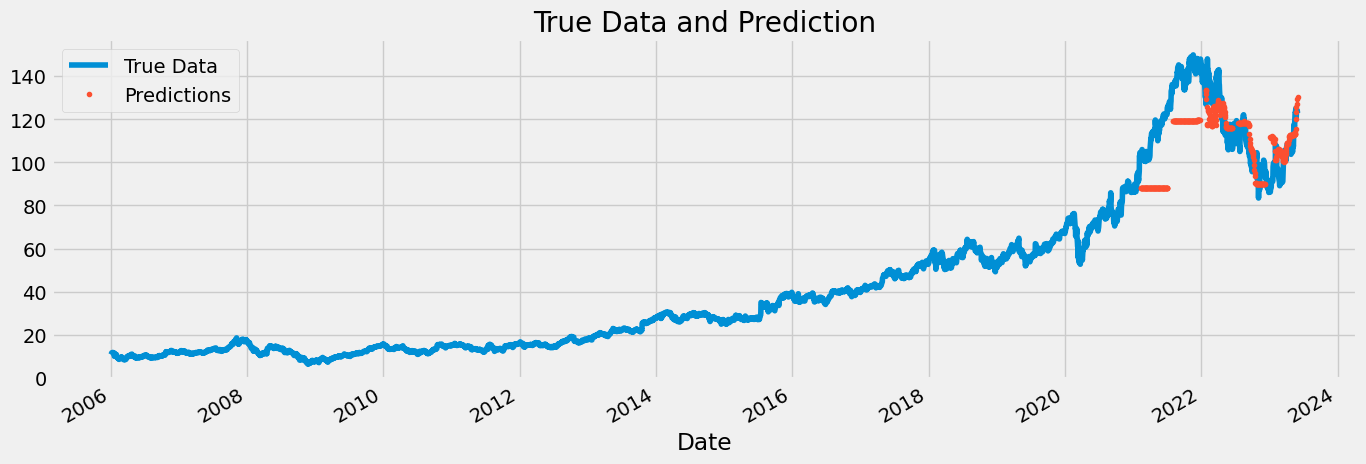

In [18]:
# Concatenate all predictions into a single DataFrame
predictions = pd.concat(preds)

# Merge predictions back into the original DataFrame
df = df.merge(predictions, how='left', left_index=True, right_index=True)

# Plotting
ax = df[['Close']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['True Data', 'Predictions'])
ax.set_title('True Data and Prediction')
plt.show()

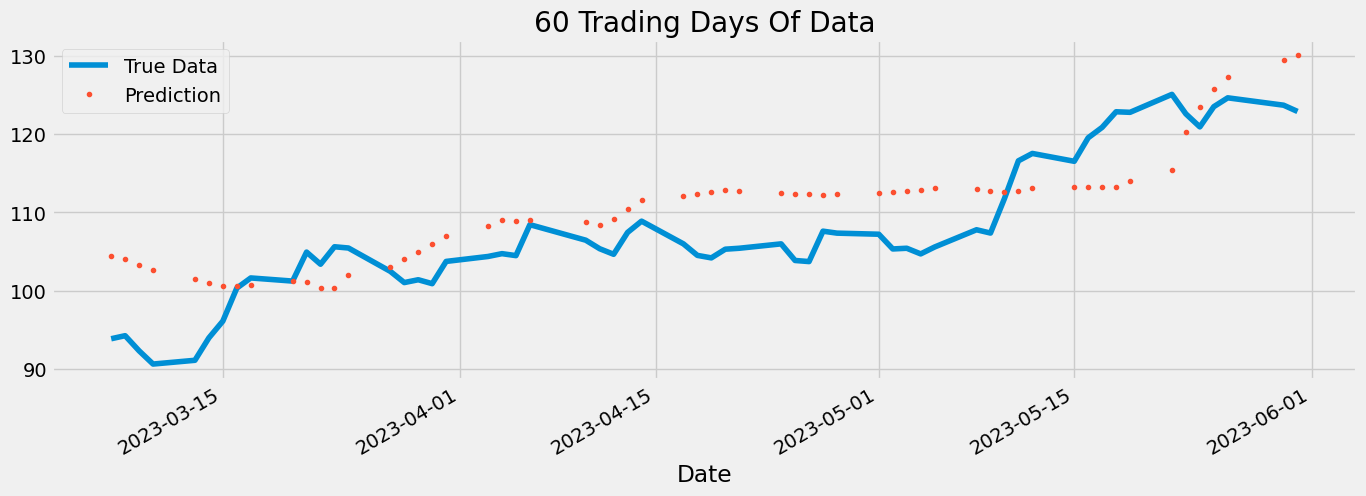

In [19]:
ax = df.loc[df.tail(60).index]['Close'] \
    .plot(figsize=(15, 5), title='60 Trading Days Of Data')
df.loc[df.tail(60).index]['prediction'] \
    .plot(style='.')
plt.legend(['True Data','Prediction'])
plt.show()